In [22]:
import rdutil
import numpy as np
import matplotlib.pyplot as plt

In [23]:
N = 10000
fs = 1e5
scenarioNUM = 1

# generate scenario
nn, nn2 = rdutil.genscenario(N, fs, scenarioNUM)

t = np.arange(N)/fs

In [24]:
# general parameters / mainly for slow time RDmap (algorithm 3)
bs = 256  # batch size
overlap = 128  # corresponds to maximum timeshift?
nbatches = int(np.floor((len(nn)-overlap)/bs))


In [25]:
import scipy.signal as signal
def xcorr(x, y):
    rxy = signal.correlate(x, y, mode='full')
    lags = np.arange(-len(x)+1, len(x))
    return lags, rxy

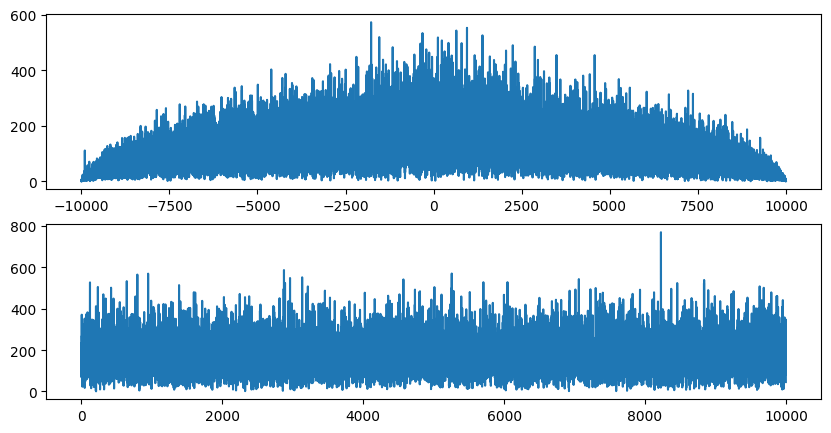

In [28]:
#########
# Algorithm 1:

# simple correlation using xcorr and fft
# note: both should give the same result, however
# the fft version is faster

lags, rxx = xcorr(nn, nn2)
[fig, ax] = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(lags, abs(rxx))
ax[1].plot(abs(np.fft.ifft(np.fft.fft(nn) * np.conj(np.fft.fft(nn2)))))

# In the plot we expect that the maximum correlation will occur
# at the time lag which nn2 is compared to nn

# however, as we also did a frequency shift, this may not be as obvious
# as it normally should be.

In [ ]:
# Algorithm 2:
# a range doppler map (correlation in both time and frequency)
# using the fft correlation presented above.


fmap = np.arange(-(bs*0.75), bs*0.75, 4)  # select some frequency bins

rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
nn2F = np.conj(np.fft.fft(nn2))

# for each frequency offset, calculate the time correlation
for fi in range(len(fmap)):
    f = fmap[fi]
    nnf = nn * np.exp(1j*2*np.pi*-f*t)

    rdmapX[fi,:] = np.fft.ifft(np.fft.fft(nnf) * nn2F)

# figure of RDMAP made using traditional FFT etc
stRDmap = np.zeros((nbatches, overlap))
sdata = np.size(stRDmap)
gridx = np.arange(0, overlap)
gridy = fmap

rdmapXTRUNC = rdmapX[:, 1:overlap]  # only need the first 'overlap' samples
plt.imshow(np.abs(rdmapXTRUNC), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')
# plt.savefig('fullrdmap.png', dpi=360)


# we expect a high intensity dot at the frequency and time shifted
# created in genscenario.m

# note: we need to truncate the time index to only the first 128 samples
# even though the correlation is calculated over all 10000 samples, most
# of them are discarded.


In [ ]:
# Algorithm 3:

# To avoid the problem of discarding so many samples. but still getting the
# benefits of "integration time" we present a RD map made using a slow time
# transform

# sometimes this algorithm is known as the FFT in batches.


stmap = np.zeros((nbatches,overlap), dtype=complex)

for si in range(nbatches):

    sig1 = nn[si*bs: (si+1)*(bs)]
    # increase the lengh of sig1 by overlap
    sig1 = np.concatenate((sig1, np.zeros(overlap)), axis=0)
    sig2 = nn2[si*bs: (si+1)*(bs) + overlap]
    xc = np.fft.ifft(np.fft.fft(sig1) * np.conj(np.fft.fft(sig2)))
    stmap[si, :]  = xc[0:overlap]

# plot the slow time correlation
plt.figure()
plt.imshow(np.abs(stmap))
plt.xlabel('Range (samples)')
plt.ylabel('Slow Time (batch #)')
# plt.savefig('slowtime.png', dpi=360)

# if we take the fft at range of 100, we can get the Doppler
plt.figure()
plt.plot(abs(np.fft.fft(stmap[:,100])))


# next step is to perform the fft for each column of of the slow time map
stRDmap = np.zeros((nbatches, overlap), dtype=complex)
for ri in np.arange(overlap):
	stRDmap[:,ri] = np.fft.fftshift(np.fft.fft(stmap[:,ri]))


plt.figure()
sdata = np.shape(stRDmap)
gridx = np.arange(0, sdata[1])
gridy = (np.arange(0, nbatches)/nbatches - 0.5) *2*bs*0.75

plt.imshow(np.abs(stRDmap), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')
# plt.savefig('batch-fft-rdmap.png', dpi=360)

# note the plot looks similar to the previous one, however it is much faster
# due to less discarded data.

# However, it does have a little less frequency resolution, due to the number of batches selected.
